In [1]:
# Link to Google Colab: https://colab.research.google.com/drive/12JmhhENHXSYbDpK68_71miXeUUX5bNEs?usp=sharing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import copy
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
import plotly.graph_objects as go



# Change the dataset by changing dataset_year variable to 2020 or 2021 
dataset_year = 2021 # or 2021

df_train = pd.read_csv(f"my_data{dataset_year}.csv", error_bad_lines=False, index_col='date', parse_dates=True)
df_test = pd.read_csv(f"my_data{dataset_year}_test.csv", error_bad_lines=False, index_col='date', parse_dates=True)

df_train = df_train.fillna(0)
df_test = df_test.fillna(0)


<ipython-input-1-57c056638451>:23: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_train = pd.read_csv(f"my_data{dataset_year}.csv", error_bad_lines=False, index_col='date', parse_dates=True)
<ipython-input-1-57c056638451>:24: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_test = pd.read_csv(f"my_data{dataset_year}_test.csv", error_bad_lines=False, index_col='date', parse_dates=True)


In [2]:
# Global prediction using simple polynomial regression. Figure and resutls

# Initialize empty lists for storing global results and selected features
results_global = []
features = []

# Train model
def polynomial_regression(degree, X_train, X_test, y_train, y_test):
    
    X_new = np.linspace(min(X_test), max(X_test), 61).reshape(61, 1)

    # PolynomialFeatures generates polynomial features up to the specified degree.
    # StandardScaler scales the features to have zero mean and unit variance.
    # LinearRegression fits a linear model to the data.
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()

    # Combine the three objects into a Pipeline object which applies the three operations in sequence. 
    polynomial_regression = Pipeline([
            ("poly_features", poly_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    
    # Fit the pipeline to the training data.
    polynomial_regression.fit(X_train, y_train)

    # Predict new cases values
    y_predicted = polynomial_regression.predict(X_new)
    return y_predicted 
    


for country in df_train['location'].unique():
    # Filter data for specific country
    df_train_country = df_train[df_train['location'] == country]
    df_test_country = df_test[df_test['location'] == country]

    # Calculate correlation matrix for the country
    matrix =  df_train_country.corr(numeric_only=True)
    corr_pairs = matrix['new_cases'].drop(['new_cases'])

    # Select the feature most highly correlated with new cases
    features = corr_pairs.nlargest(1).index.tolist()
    
    # Select features for train set and test set
    X_train = df_train_country[features[0]].values
    X_test = df_test_country[features[0]].values
    y_train = df_train_country["new_cases"].values
    y_test = df_test_country["new_cases"].values
    X_train = X_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # Model return predicted values
    y_newbig = polynomial_regression(2, X_train, X_test, y_train, y_test)

    # Plot the predicted and actual values
    plt.subplots(figsize=(10, 10))
    plt.plot(df_test_country.index, y_newbig,'r-o', label="Predicted ", linewidth=2)
    plt.plot(df_test_country.index, y_test, "b-o", label="Actual " , linewidth=3)
    plt.legend(loc="upper left")
    plt.title('COVID-19 New Cases Prediction in ' + country)
    plt.xlabel("Date")
    plt.ylabel("New Cases")
    plt.show()

    # Calculate regression metrics including MSE, RMSE, MAE, and R2 score
    mse = mean_squared_error(y_test, y_newbig)
    print("Mean squared error(MSE): ", mse)
    poly_reg_rmse = np.sqrt(mean_squared_error(y_test, y_newbig))
    print("RMSE: " , poly_reg_rmse)
    mae = mean_absolute_error(y_test, y_newbig)
    print("Mean Absolute Error (MAE):", mae)
    r2 = r2_score(y_test, y_newbig)
    print("R2 score: ", r2_score(y_test, y_newbig))

    # Append results to list of results
    results_global.append([country, y_newbig.mean().round(0), mse, poly_reg_rmse, mae, r2])


results_df = pd.DataFrame(results_global, columns=['location', 'new_cases', 'MSE', 'RMSE', 'MAE', 'R2'])

# Calculate mean values
column_means = results_df.mean().round(2)

results_df.to_csv(f'results_all_countries_simple_poly{dataset_year}.csv', index=False)

# Create a table showing the regression results for each location
results_transposed = np.array(results_global).T.tolist()
fig_table = go.Figure(data=[go.Table(
    header=dict(values=['LOCATION', 'New cases', 'MSE', 'RMSE', 'MAE', 'R2 SCORE'], font=dict(size=14)),
    cells=dict(values=results_transposed, font=dict(size=14) , align='left'))
])

fig_table.update_layout(
    title=f'COVID-19 New Cases and Regression Metrics in {dataset_year}',
    width= 1500,
    height=1500,
)

fig_table.show()

# Create a table showing the mean values for the regression metrics
fig_table_mean = go.Figure(data=[go.Table(
    header=dict(values=['New cases', 'MSE', 'RMSE', 'MAE', 'R2 SCORE'],font=dict(size=18)),
    cells=dict(values=column_means, font=dict(size=18) , height=30 , align='left'))
])

fig_table_mean.update_layout(
    title={
        'text': f'Global COVID-19 New Cases Prediction and Regression Metrics in {dataset_year}',
        'font': {'size': 20}
    },
    width= 1600,
    height=500,
)

fig_table_mean.show()

Output hidden; open in https://colab.research.google.com to view.

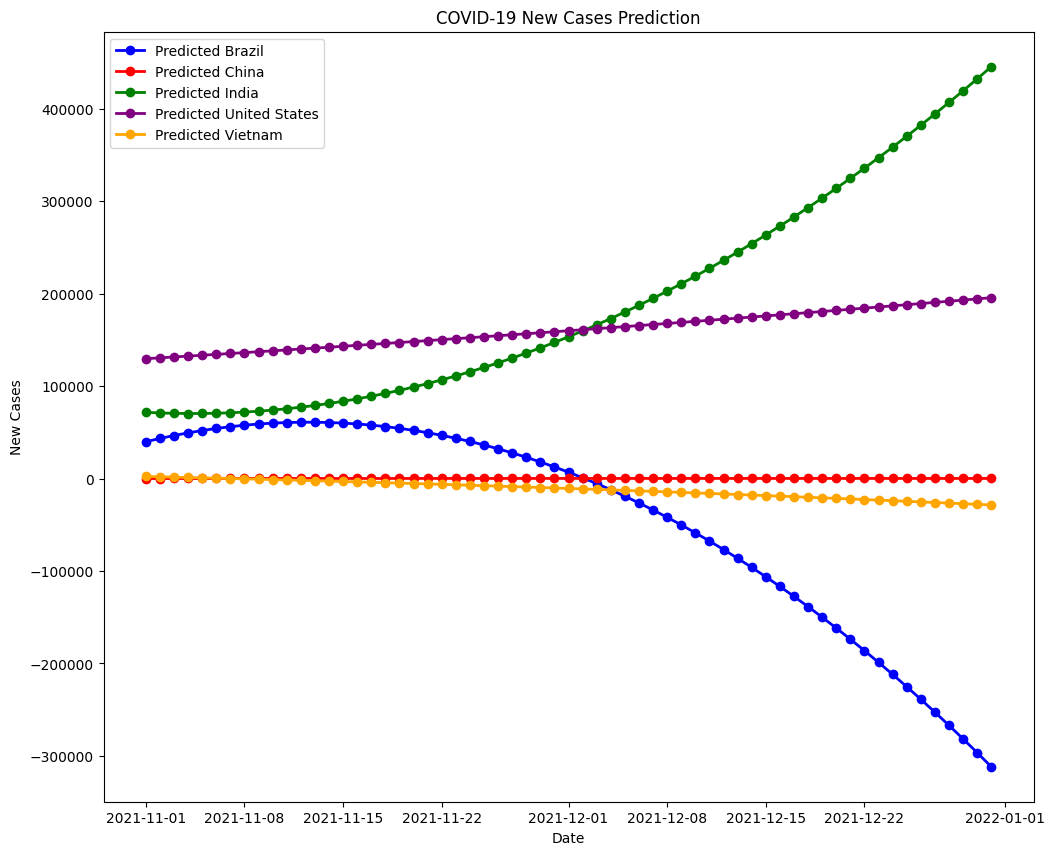

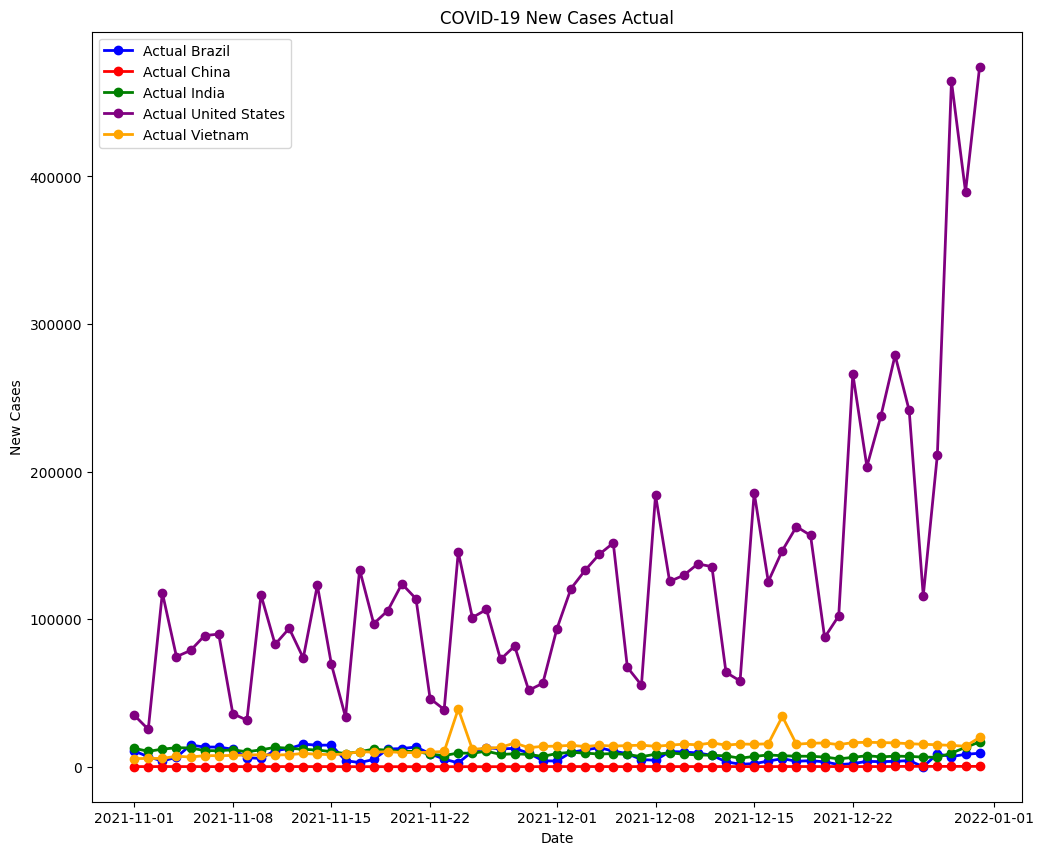

In [3]:
# Top 5 countries prediction using simple polynomial regression. Five countries in one figure 
results_5 = []
features = []
colors = ['blue', 'red', 'green', 'purple', 'orange']

# Append global results to list of results
row = ['Global', column_means[0], column_means[1], column_means[2], column_means[3], column_means[4]]
results_5.append(row)    

i = 0
for country in df_train['location'].unique():
    # Filter data for specific country 
    if country != 'Brazil' and country != 'Vietnam' and country != 'India' and country != 'China' and country != 'United States':
      continue
    df_train_country = df_train[df_train['location'] == country]
    df_test_country = df_test[df_test['location'] == country]

    # Calculate correlation matrix for the country
    matrix =  df_train_country.corr(numeric_only=True)
    corr_pairs = matrix['new_cases'].drop(['new_cases'])

    # Select the feature most highly correlated with new cases
    features = corr_pairs.nlargest(1).index.tolist()

    # Select features for train set and test set
    X_train = df_train_country[features[0]].values
    X_test = df_test_country[features[0]].values
    y_train = df_train_country["new_cases"].values
    y_test = df_test_country["new_cases"].values
    X_train = X_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # Model return predicted values
    y_newbig = polynomial_regression(2, X_train, X_test, y_train, y_test)
    
    # Plotting prediction line
    plt.figure(1, figsize=(12, 10))
    plt.plot(df_test_country.index, y_newbig, marker='o', color=colors[i], label="Predicted " + country, linewidth=2)
    plt.figure(2, figsize=(12, 10))
    plt.plot(df_test_country.index, y_test , marker='o', color=colors[i], label="Actual " + country, linewidth=2)

    # Calculate regression metrics including MSE, RMSE, MAE, and R2 score
    mse = np.mean((y_test - y_newbig) ** 2)
    poly_reg_rmse = np.sqrt(mean_squared_error(y_test, y_newbig))
    mae = mean_absolute_error(y_test, y_newbig)
    r2 = r2_score(y_test, y_newbig)

    # Append results to list of results
    results_5.append([country, y_newbig.mean().round(0), mse, poly_reg_rmse, mae, r2])
    i += 1

# Plotting prediction line
plt.figure(1, figsize=(12, 10))
plt.legend(loc="upper left")
plt.title('COVID-19 New Cases Prediction')
plt.xlabel("Date")
plt.ylabel("New Cases")


# Plotting actual line
plt.figure(2, figsize=(12, 10))
plt.legend(loc="upper left")
plt.title('COVID-19 New Cases Actual')
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.show()

results_df = pd.DataFrame(results_5, columns=['location', 'new_cases', 'MSE', 'RMSE', 'MAE', 'R2'])
results_df.to_csv(f'results_global_and_top5_simple_poly{dataset_year}.csv', index=False)

# Create Table results
results_transposed = np.array(results_5).T.tolist()
fig_table = go.Figure(data=[go.Table(
    header=dict(values=['Location', 'New cases', 'MSE', 'RMSE', 'MAE', 'R2 SCORE'], font=dict(size=18)),
    cells=dict(values=results_transposed, font=dict(size=18), height=30, align='left'))
])

fig_table.update_layout(
    title={
        'text': f'COVID-19 New Cases in Global and 5 countries and Regression Metrics in {dataset_year}',
        'font': {'size': 20} 
    },
    width= 1780,
    height=800,
)

fig_table.show()

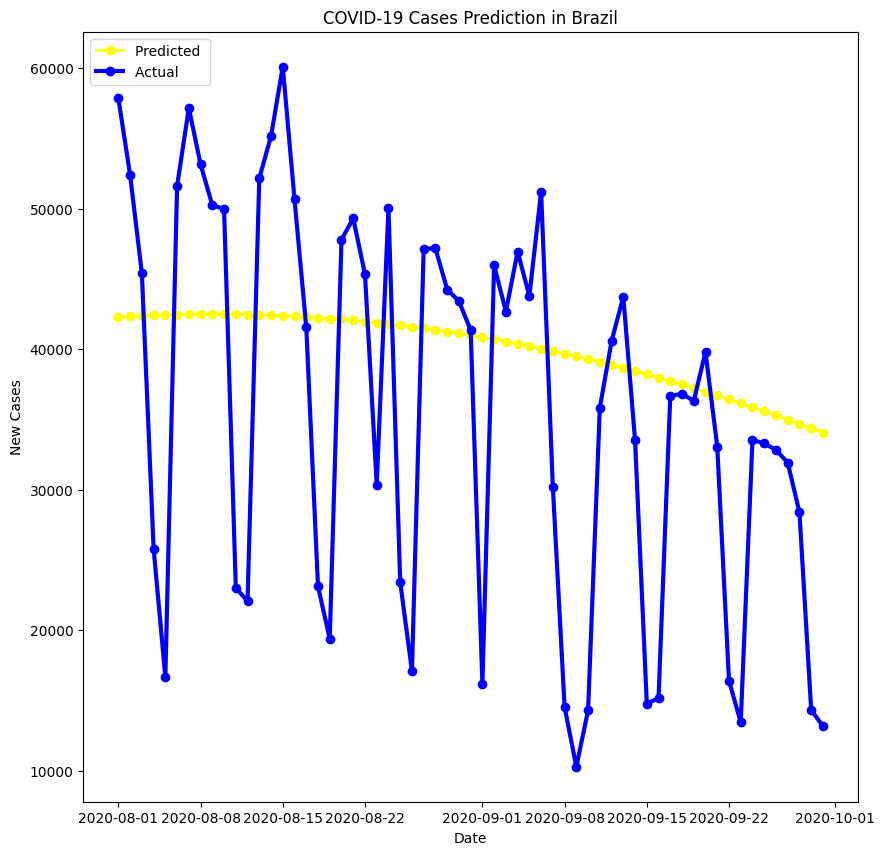

Mean squared error(MSE):  187840346.3443286
RMSE:  13705.485994459614
Mean Absolute Error (MAE): 10830.048785197567
R2 score:  0.04984916845710119


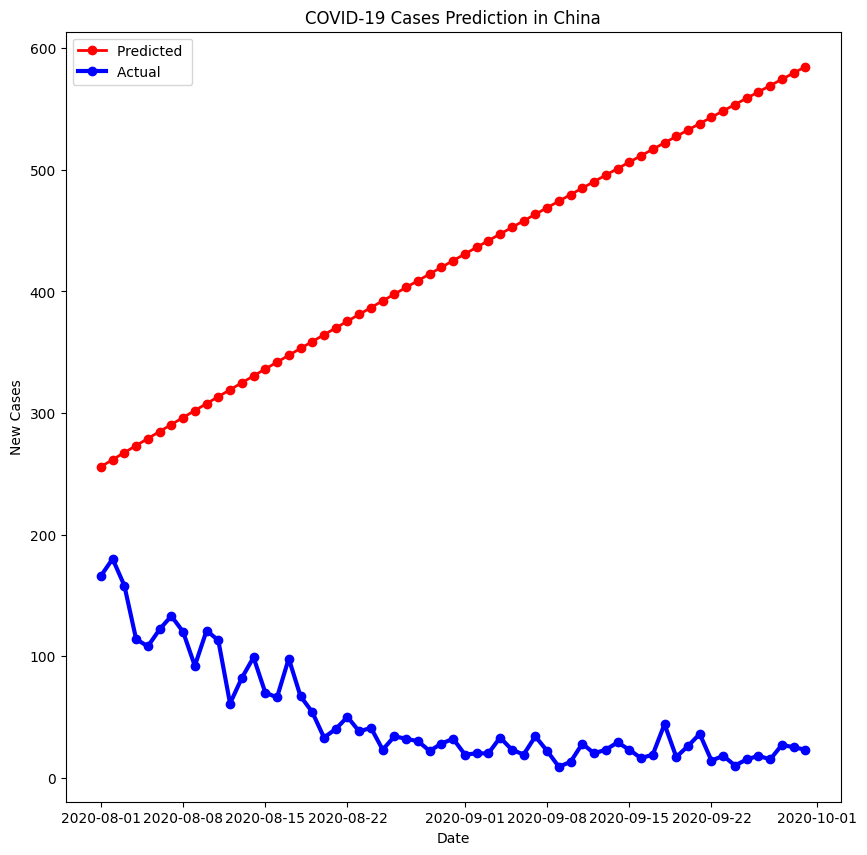

Mean squared error(MSE):  157273.80238819047
RMSE:  396.5776120612338
Mean Absolute Error (MAE): 373.08040902081746
R2 score:  -83.64763390605245


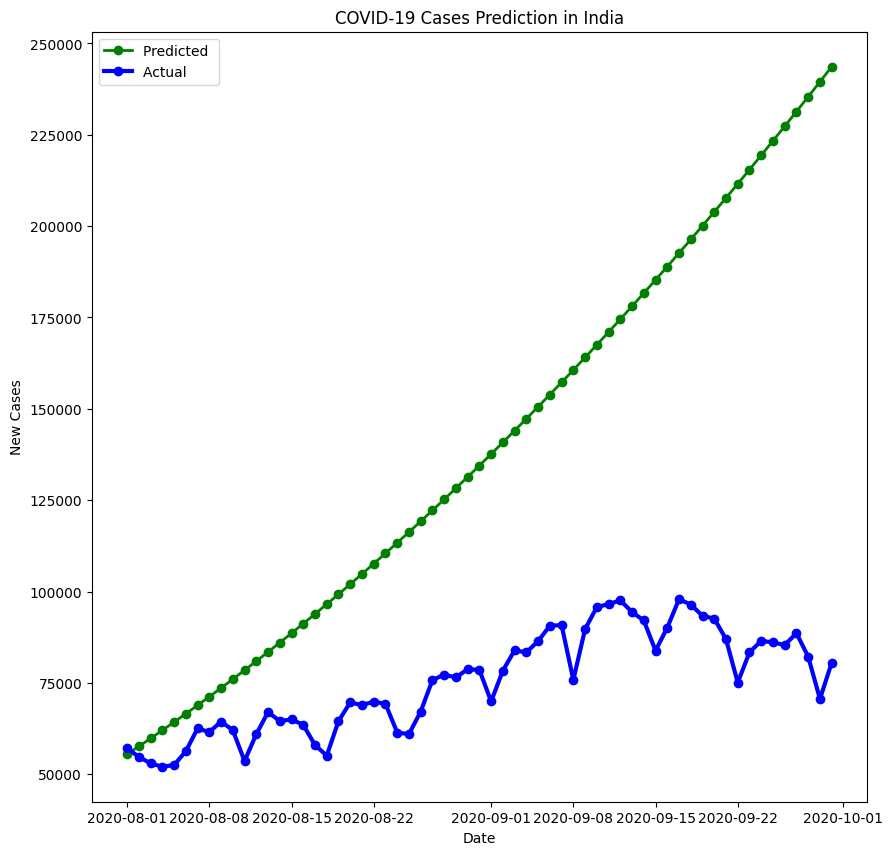

Mean squared error(MSE):  6184622205.360304
RMSE:  78642.36902179578
Mean Absolute Error (MAE): 64524.66687823582
R2 score:  -31.619245794419555


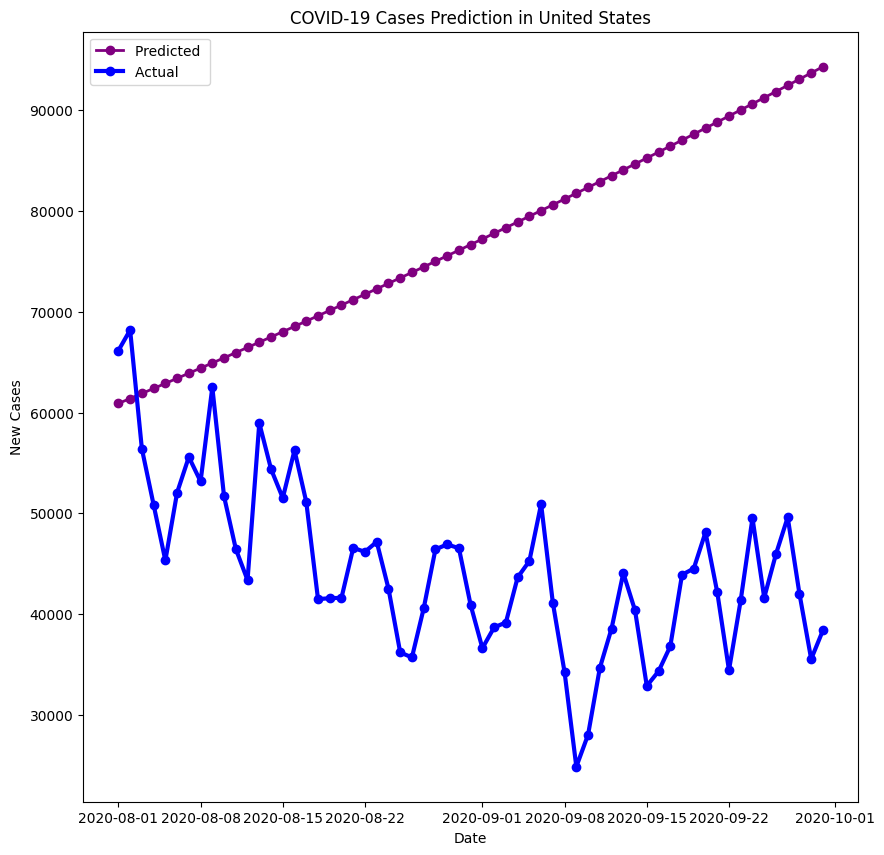

Mean squared error(MSE):  1306564648.9192452
RMSE:  36146.43341906979
Mean Absolute Error (MAE): 32678.894478474333
R2 score:  -17.466463788350804


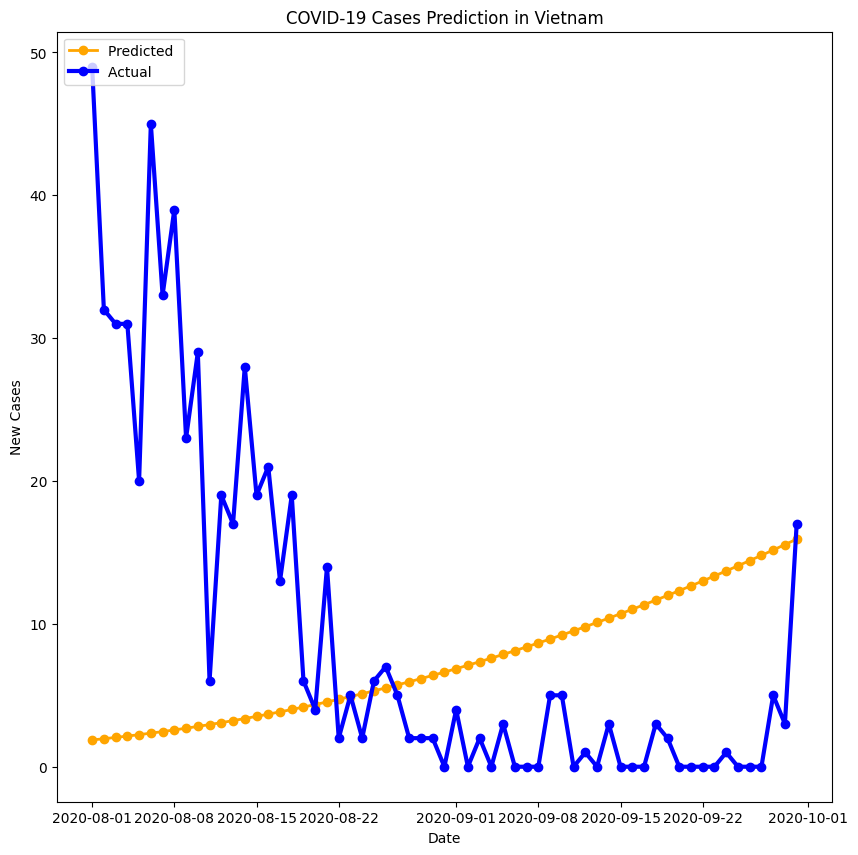

Mean squared error(MSE):  252.24696683317
RMSE:  15.882284685559883
Mean Absolute Error (MAE): 12.171591440924335
R2 score:  -0.5744860478382954


In [ ]:
# Create separate figures for each of the Top 5 predicted countries. Each figure should display a single country
features = []
colors = ['yellow', 'red', 'green', 'purple', 'orange']
i = 0
for country in df_train['location'].unique():
    # Filter data for specific country
    if country != 'Brazil' and country != 'Vietnam' and country != 'India' and country != 'China' and country != 'United States':
      continue
    df_train_country = df_train[df_train['location'] == country]
    df_test_country = df_test[df_test['location'] == country]

    # Calculate correlation matrix for the country
    matrix =  df_train_country.corr(numeric_only=True)
    corr_pairs = matrix['new_cases'].drop(['new_cases'])

    # Select the feature most highly correlated with new cases
    features = corr_pairs.nlargest(1).index.tolist()
    
    # Select features for train set and test set
    X_train = df_train_country[features[0]].values
    X_test = df_test_country[features[0]].values
    y_train = df_train_country["new_cases"].values
    y_test = df_test_country["new_cases"].values
    X_train = X_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # Model return predicted values
    y_newbig = polynomial_regression(2, X_train, X_test, y_train, y_test)

    # Plot the predicted and actual values
    plt.subplots(figsize=(10, 10))
    plt.plot(df_test_country.index, y_newbig, marker='o' , color=colors[i], label="Predicted ", linewidth=2)
    plt.plot(df_test_country.index, y_test, marker='o' , color="b",label="Actual " , linewidth=3)
    plt.legend(loc="upper left")
    plt.title('COVID-19 Cases Prediction in ' + country)
    plt.xlabel("Date")
    plt.ylabel("New Cases")
    plt.show()

    # Calculate regression metrics including MSE, RMSE, MAE, and R2 score
    mse = np.mean((y_test - y_newbig) ** 2)
    print("Mean squared error(MSE): ", mse)
    poly_reg_rmse = np.sqrt(mean_squared_error(y_test, y_newbig))
    print("RMSE: " , poly_reg_rmse)
    mae = mean_absolute_error(y_test, y_newbig)
    print("Mean Absolute Error (MAE):", mae)
    r2 = r2_score(y_test, y_newbig)
    print("R2 score: ", r2_score(y_test, y_newbig))
    i += 1




In [ ]:
# Testing global prediction using simple polynomial regression in difference degrees
results_global = []
features = []

# Flatten a nested list
def flatten(l):
    flat_list = []
    for item in l:
        if isinstance(item, (list, np.ndarray)):
            flat_list.extend(flatten(item))
        else:
            flat_list.append(item)
    return flat_list

# Define the degrees to test
degrees = [2, 3, 4, 5, 6]
column_means = []

for degree in degrees:
  for country in df_train['location'].unique():
      # Filter data for specific country
      df_train_country = df_train[df_train['location'] == country]
      df_test_country = df_test[df_test['location'] == country]

      # Calculate correlation matrix for the country
      matrix =  df_train_country.corr(numeric_only=True)
      corr_pairs = matrix['new_cases'].drop(['new_cases'])

      # Select the feature most highly correlated with new cases
      features = corr_pairs.nlargest(1).index.tolist()
      
      # Select features for train set and test set
      X_train = df_train_country[features[0]].values
      X_test = df_test_country[features[0]].values
      y_train = df_train_country["new_cases"].values
      y_test = df_test_country["new_cases"].values
      X_train = X_train.reshape(-1, 1)
      X_test = X_test.reshape(-1, 1)
      y_train = y_train.reshape(-1, 1)
      y_test = y_test.reshape(-1, 1)

      # Model return predicted values
      y_newbig = polynomial_regression(degree, X_train, X_test, y_train, y_test)

      # Calculate regression metrics including MSE, RMSE, MAE, and R2 score
      mse = mean_squared_error(y_test, y_newbig)
      poly_reg_rmse = np.sqrt(mean_squared_error(y_test, y_newbig))
      mae = mean_absolute_error(y_test, y_newbig)
      r2 = r2_score(y_test, y_newbig)
      # Append results to list of results
      results_global.append([country, mse, poly_reg_rmse, mae, r2])

  results_df = pd.DataFrame(results_global, columns=['location', 'MSE', 'RMSE', 'MAE', 'R2'])
  results_global = []
  original_list = [degree, np.array(results_df.mean().round(2))]

  # Flatten the list for easy display in a table
  new_list = flatten(original_list)

  # Calculate mean values
  column_means.append(new_list)


# Create a table showing the mean values for the regression metrics in difference degrees
results_transposed = np.array(column_means).T.tolist()

fig_table_mean = go.Figure(data=[go.Table(
    header=dict(values=['Degree', 'MSE', 'RMSE', 'MAE', 'R2 SCORE'], font=dict(size=20)),
    cells=dict(values=results_transposed , font=dict(size=18), height=30, align='left'))
])

fig_table_mean.update_layout(
    title=f'Global COVID-19 New Cases Prediction and Regression Metrics in {dataset_year}',
    width= 1600,
    height=500,
)

fig_table_mean.show()

<ipython-input-23-4120f18a0f64>:55: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

<ipython-input-23-4120f18a0f64>:55: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

<ipython-input-23-4120f18a0f64>:55: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

<ipython-input-23-4120f18a0f64>:55: FutureWarning:

The de

In [ ]:
# Corrlation train set and test set for 5 countries : Brazil, Vietnam, India, China and United States
correlation_train_test = []
features = []
for country in df_train['location'].unique():
    # Filter data for specific country
    if country != 'Brazil' and country != 'Vietnam' and country != 'India' and country != 'China' and country != 'United States':
      continue
    df_train_country = df_train[df_train['location'] == country]
    df_test_country = df_test[df_test['location'] == country]

    # Calculate correlation matrix for the country
    matrix =  df_train_country.corr(numeric_only=True)
    matrix_test =  df_test_country.corr(numeric_only=True)
    corr_pairs = matrix['new_cases'].drop(['new_cases'])

    # Select the feature most highly correlated with new cases
    features = corr_pairs.nlargest(1).index.tolist()

    # Calculate the correlation coefficient between new_cases and the selected feature in the train and test dataset
    corr_array1 = matrix.loc[['new_cases'], [features[0]]].to_numpy().flatten()
    corr_array2 = matrix_test.loc[['new_cases'], [features[0]]].to_numpy().flatten()
    row = {'Country': country, 'Feature 1': corr_array1[0], 'Feature 2': corr_array2[0] }
    correlation_train_test.append(row)

# Define a function to create a table visualization of the correlation results
def correlation_f(table):

    table_data = [[row['Country'], row['Feature 1'], row['Feature 2']] for row in table]

    # Create a plotly figure with a table visualization of the correlation results
    fig_table_mean = go.Figure(data=[go.Table(
        header=dict(values=['Country', 'Attribute on train set', 'Attribute on test set'], font=dict(size=20)),
        cells=dict(values=np.array(table_data).T.tolist(), font=dict(size=18), height=30, align='left'))
    ])

    fig_table_mean.update_layout(
        title=f'The correlation coefficient of the attribute on the dataset in {dataset_year} of five countries using Polynomial Regression',
        font={'size': 20},
        width=1800,
        height=500,
    )
    fig_table_mean.show()

correlation_f(correlation_train_test)
